In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load strategy results
project_root = os.path.dirname(os.getcwd())
results_path = os.path.join(project_root, 'Super_Agent_Output', 'regime_strategy_results.csv')

df = pd.read_csv(results_path, index_col=0, parse_dates=True)
print(f"Loaded {len(df)} months of strategy results")
print(f"Date Range: {df.index.min().date()} to {df.index.max().date()}")
print(f"\nColumns: {list(df.columns)}")

Loaded 438 months of strategy results
Date Range: 1988-05-31 to 2024-10-31

Columns: ['hrp_turnover', 'rf_rate', 'hrp_return', 'predicted_regime', 'prob_bull', 'actual_regime', 'financing_spread', 'allocation_binary', 'regime_binary_return', 'allocation_prob', 'regime_prob_return', 'allocation_prob_scaled', 'regime_prob_scaled_return', 'prob_scale_factor', 'inner_cost_stage1', 'outer_cost_stage2', 'turnover_NoDur', 'turnover_Durbl', 'turnover_Manuf', 'turnover_Enrgy', 'turnover_Chems', 'turnover_BusEq', 'turnover_Telcm', 'turnover_Utils', 'turnover_Shops', 'turnover_Hlth', 'turnover_Money', 'turnover_Other', 'inner_cost', 'outer_cost_buyhold', 'financing_cost_buyhold', 'hrp_return_net', 'outer_cost_binary', 'financing_cost_binary', 'regime_binary_return_net', 'outer_cost_prob', 'financing_cost_prob', 'regime_prob_return_net', 'outer_cost_scaled', 'financing_cost_scaled', 'regime_prob_scaled_return_net']


In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# DRAWDOWN COMPUTATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════

def compute_drawdown_series(returns: pd.Series) -> pd.DataFrame:
    """
    Compute drawdown series from returns.
    
    Returns DataFrame with:
    - cumulative: Cumulative wealth (starting at 1)
    - running_max: Running maximum of cumulative wealth
    - drawdown: Current drawdown (negative values)
    """
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    
    return pd.DataFrame({
        'cumulative': cumulative,
        'running_max': running_max,
        'drawdown': drawdown
    })


def get_top_drawdowns(returns: pd.Series, n: int = 5) -> pd.DataFrame:
    """
    Get the top N drawdown episodes with start, trough, end dates.
    """
    dd_df = compute_drawdown_series(returns)
    drawdown = dd_df['drawdown']
    
    # Find drawdown episodes
    episodes = []
    in_drawdown = False
    start_date = None
    
    for date, dd in drawdown.items():
        if dd < 0 and not in_drawdown:
            # Start of new drawdown
            in_drawdown = True
            start_date = date
        elif dd == 0 and in_drawdown:
            # End of drawdown (recovered)
            episode_dd = drawdown[start_date:date]
            trough_date = episode_dd.idxmin()
            max_dd = episode_dd.min()
            episodes.append({
                'start': start_date,
                'trough': trough_date,
                'end': date,
                'max_drawdown': max_dd,
                'duration_months': len(episode_dd),
                'recovery_months': len(drawdown[trough_date:date])
            })
            in_drawdown = False
    
    # Handle ongoing drawdown
    if in_drawdown:
        episode_dd = drawdown[start_date:]
        trough_date = episode_dd.idxmin()
        episodes.append({
            'start': start_date,
            'trough': trough_date,
            'end': None,  # Ongoing
            'max_drawdown': episode_dd.min(),
            'duration_months': len(episode_dd),
            'recovery_months': None
        })
    
    # Sort by max drawdown and return top N
    episodes_df = pd.DataFrame(episodes)
    if len(episodes_df) > 0:
        episodes_df = episodes_df.sort_values('max_drawdown').head(n).reset_index(drop=True)
    
    return episodes_df


print("✓ Drawdown functions defined")

✓ Drawdown functions defined


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# COMPUTE DRAWDOWNS FOR BOTH STRATEGIES
# ═══════════════════════════════════════════════════════════════════════════════

# Extract NET returns
hrp_returns = df['hrp_return_net']
scaled_returns = df['regime_prob_scaled_return_net']

# Compute drawdown series
hrp_dd = compute_drawdown_series(hrp_returns)
scaled_dd = compute_drawdown_series(scaled_returns)

print("="*70)
print("DRAWDOWN SUMMARY")
print("="*70)
print(f"\n{'Metric':<30} {'Static HRP':>15} {'P(Bull) Scaled':>15}")
print("-"*60)
print(f"{'Max Drawdown':<30} {hrp_dd['drawdown'].min():>15.2%} {scaled_dd['drawdown'].min():>15.2%}")
print(f"{'Avg Drawdown':<30} {hrp_dd['drawdown'].mean():>15.2%} {scaled_dd['drawdown'].mean():>15.2%}")
print(f"{'Time in Drawdown':<30} {(hrp_dd['drawdown'] < 0).mean():>15.1%} {(scaled_dd['drawdown'] < 0).mean():>15.1%}")

DRAWDOWN SUMMARY

Metric                              Static HRP  P(Bull) Scaled
------------------------------------------------------------
Max Drawdown                           -47.07%         -25.23%
Avg Drawdown                            -5.21%          -2.90%
Time in Drawdown                         63.7%           59.4%


In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# TOP 5 DRAWDOWNS FOR EACH STRATEGY
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("TOP 5 DRAWDOWN EPISODES: STATIC HRP (NET)")
print("="*70)
top_hrp = get_top_drawdowns(hrp_returns, n=5)
print(top_hrp.to_string(index=False))

print("\n" + "="*70)
print("TOP 5 DRAWDOWN EPISODES: P(BULL) SCALED (NET)")
print("="*70)
top_scaled = get_top_drawdowns(scaled_returns, n=5)
print(top_scaled.to_string(index=False))

TOP 5 DRAWDOWN EPISODES: STATIC HRP (NET)
     start     trough        end  max_drawdown  duration_months  recovery_months
2007-10-31 2009-01-31 2012-01-31     -0.470750               52               37
2000-09-30 2002-08-31 2004-11-30     -0.320919               51               28
2020-01-31 2020-02-29 2020-07-31     -0.207568                7                6
2021-12-31 2022-08-31 2024-01-31     -0.182860               26               18
1998-06-30 1998-07-31 1998-10-31     -0.145584                5                4

TOP 5 DRAWDOWN EPISODES: P(BULL) SCALED (NET)
     start     trough        end  max_drawdown  duration_months  recovery_months
2000-12-31 2002-08-31 2003-12-31     -0.252323               37               17
2021-12-31 2022-08-31 2023-11-30     -0.145542               24               16
2010-04-30 2010-05-31 2010-11-30     -0.139722                8                7
1998-06-30 1998-07-31 1998-10-31     -0.136215                5                4
2011-05-31 2011-08-3

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# CRISIS-SPECIFIC DRAWDOWNS
# ═══════════════════════════════════════════════════════════════════════════════

# Define crisis periods
crises = {
    '1987 Black Monday': ('1987-08-01', '1988-06-30'),
    '2000-2003 Dot-Com': ('2000-03-01', '2003-03-31'),
    '2008 GFC': ('2007-10-01', '2009-06-30'),
    '2020 COVID': ('2020-01-01', '2020-06-30'),
    '2022 Rate Hikes': ('2022-01-01', '2022-12-31')
}

print("="*70)
print("CRISIS-SPECIFIC DRAWDOWNS")
print("="*70)
print(f"\n{'Crisis':<25} {'Period':<25} {'HRP DD':>12} {'Scaled DD':>12} {'Diff':>10}")
print("-"*85)

crisis_results = []
for crisis_name, (start, end) in crises.items():
    # Filter to crisis period
    mask = (df.index >= start) & (df.index <= end)
    if mask.sum() == 0:
        print(f"{crisis_name:<25} {'[No data]':<25}")
        continue
    
    # Compute drawdown within crisis period
    hrp_crisis = compute_drawdown_series(hrp_returns[mask])
    scaled_crisis = compute_drawdown_series(scaled_returns[mask])
    
    hrp_max_dd = hrp_crisis['drawdown'].min()
    scaled_max_dd = scaled_crisis['drawdown'].min()
    diff = scaled_max_dd - hrp_max_dd  # Negative = Scaled did better
    
    period_str = f"{start[:7]} to {end[:7]}"
    print(f"{crisis_name:<25} {period_str:<25} {hrp_max_dd:>12.2%} {scaled_max_dd:>12.2%} {diff:>+10.2%}")
    
    crisis_results.append({
        'Crisis': crisis_name,
        'Period': period_str,
        'HRP_DD': hrp_max_dd,
        'Scaled_DD': scaled_max_dd,
        'Diff': diff,
        'Scaled_Better': diff < 0
    })

crisis_df = pd.DataFrame(crisis_results)
print("\nNote: Negative Diff means P(Bull) Scaled had SMALLER drawdown (better)")

CRISIS-SPECIFIC DRAWDOWNS

Crisis                    Period                          HRP DD    Scaled DD       Diff
-------------------------------------------------------------------------------------
1987 Black Monday         1987-08 to 1988-06              -0.03%        0.00%     +0.03%
2000-2003 Dot-Com         2000-03 to 2003-03             -32.09%      -25.23%     +6.86%
2008 GFC                  2007-10 to 2009-06             -45.81%       -5.99%    +39.82%
2020 COVID                2020-01 to 2020-06             -13.37%       -1.77%    +11.60%
2022 Rate Hikes           2022-01 to 2022-12             -15.44%       -8.61%     +6.83%

Note: Negative Diff means P(Bull) Scaled had SMALLER drawdown (better)


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# GFC DRAWDOWN (2007-05 to 2009-01) - For Report
# ═══════════════════════════════════════════════════════════════════════════════

# Define the exact GFC period for the report
gfc_start = '2007-05-01'
gfc_end = '2009-01-31'

mask_gfc = (df.index >= gfc_start) & (df.index <= gfc_end)
print(f"GFC Period: {gfc_start[:7]} to {gfc_end[:7]}")
print(f"Months in period: {mask_gfc.sum()}")

# Compute drawdown within this specific period
hrp_gfc = compute_drawdown_series(hrp_returns[mask_gfc])
scaled_gfc = compute_drawdown_series(scaled_returns[mask_gfc])

hrp_gfc_dd = hrp_gfc['drawdown'].min()
scaled_gfc_dd = scaled_gfc['drawdown'].min()

print(f"\n{'Strategy':<25} {'Max Drawdown':>15}")
print("-"*42)
print(f"{'Buy & Hold HRP':<25} {hrp_gfc_dd:>15.2%}")
print(f"{'P(Bull) Scaled':<25} {scaled_gfc_dd:>15.2%}")
print(f"\nDrawdown Reduction: {hrp_gfc_dd - scaled_gfc_dd:.1%} (absolute)")
print(f"Drawdown Reduction: {(hrp_gfc_dd - scaled_gfc_dd) / abs(hrp_gfc_dd) * 100:.1f}% (relative)")

# For copy-paste into report
print(f"\n📋 FOR REPORT:")
print(f"   HRP worst drawdown (2007–2009): {hrp_gfc_dd:.1%}")
print(f"   P(Bull) Scaled drawdown: {scaled_gfc_dd:.1%}")

GFC Period: 2007-05 to 2009-01
Months in period: 21

Strategy                     Max Drawdown
------------------------------------------
Buy & Hold HRP                    -47.07%
P(Bull) Scaled                     -6.59%

Drawdown Reduction: -40.5% (absolute)
Drawdown Reduction: -86.0% (relative)

📋 FOR REPORT:
   HRP worst drawdown (2007–2009): -47.1%
   P(Bull) Scaled drawdown: -6.6%


In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIND PERIODS WHERE P(BULL) SCALED HAD LARGER DRAWDOWN THAN HRP
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PERIODS WHERE P(BULL) SCALED UNDERPERFORMED HRP (Larger Drawdown)")
print("="*70)

# Compute point-in-time drawdown comparison
dd_comparison = pd.DataFrame({
    'hrp_dd': hrp_dd['drawdown'],
    'scaled_dd': scaled_dd['drawdown'],
    'scaled_worse': scaled_dd['drawdown'] < hrp_dd['drawdown']  # More negative = worse
})

# Find periods where scaled had worse (more negative) drawdown
worse_periods = dd_comparison[dd_comparison['scaled_worse']].copy()
worse_periods['dd_diff'] = worse_periods['scaled_dd'] - worse_periods['hrp_dd']

print(f"\nTotal months where P(Bull) Scaled had larger drawdown: {len(worse_periods)} / {len(df)} ({len(worse_periods)/len(df):.1%})")

# Group consecutive months into episodes
if len(worse_periods) > 0:
    # Sort worst episodes by drawdown difference
    worst_episodes = worse_periods.nsmallest(10, 'dd_diff')
    
    print("\nTop 10 WORST months for P(Bull) Scaled vs HRP:")
    print(f"{'Date':<15} {'HRP DD':>12} {'Scaled DD':>12} {'Excess DD':>12}")
    print("-"*55)
    for date, row in worst_episodes.iterrows():
        print(f"{date.strftime('%Y-%m'):<15} {row['hrp_dd']:>12.2%} {row['scaled_dd']:>12.2%} {row['dd_diff']:>12.2%}")
else:
    print("\n✓ P(Bull) Scaled NEVER had a larger drawdown than Static HRP!")

PERIODS WHERE P(BULL) SCALED UNDERPERFORMED HRP (Larger Drawdown)

Total months where P(Bull) Scaled had larger drawdown: 114 / 438 (26.0%)

Top 10 WORST months for P(Bull) Scaled vs HRP:
Date                  HRP DD    Scaled DD    Excess DD
-------------------------------------------------------
2022-10               -5.55%       -8.91%       -3.36%
2016-04               -0.30%       -3.49%       -3.19%
2022-02               -3.36%       -6.50%       -3.14%
2022-01               -6.08%       -8.82%       -2.74%
2022-12               -6.41%       -9.08%       -2.67%
2021-12               -4.21%       -6.79%       -2.58%
2016-03               -1.38%       -3.66%       -2.28%
2007-07               -2.57%       -4.77%       -2.20%
2021-08               -4.12%       -6.33%       -2.20%
1994-12               -1.72%       -3.88%       -2.16%


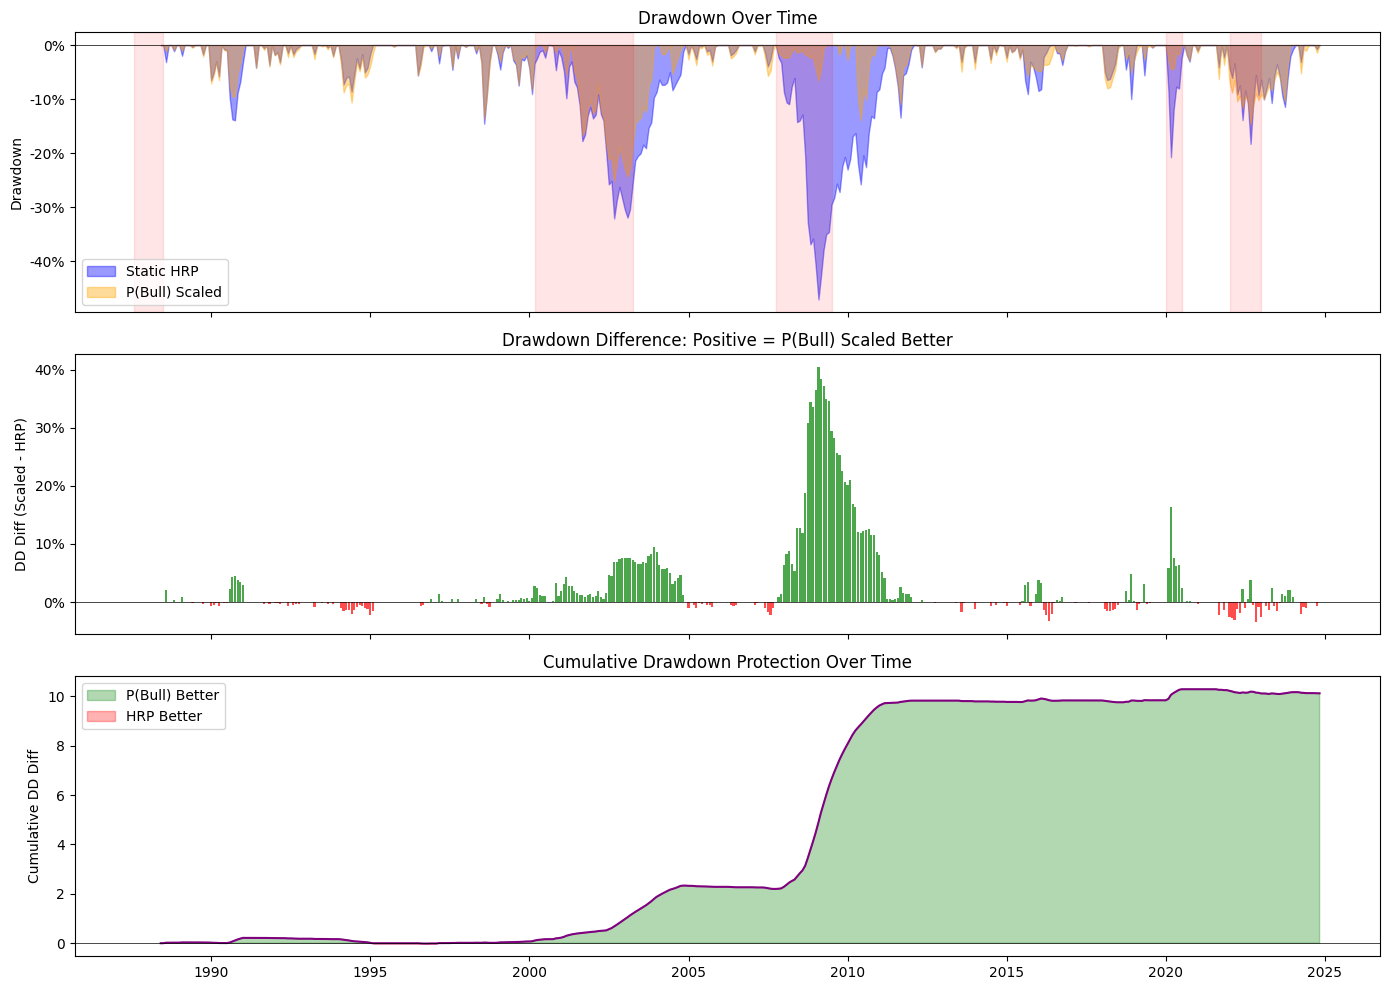

✓ Drawdown analysis chart saved


In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# VISUALIZE DRAWDOWN COMPARISON
# ═══════════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Drawdowns over time
ax1 = axes[0]
ax1.fill_between(hrp_dd.index, hrp_dd['drawdown'], 0, alpha=0.4, label='Static HRP', color='blue')
ax1.fill_between(scaled_dd.index, scaled_dd['drawdown'], 0, alpha=0.4, label='P(Bull) Scaled', color='orange')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylabel('Drawdown')
ax1.set_title('Drawdown Over Time')
ax1.legend(loc='lower left')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Mark crises
for crisis_name, (start, end) in crises.items():
    ax1.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.1, color='red')

# Panel 2: Drawdown difference (Scaled - HRP)
ax2 = axes[1]
dd_diff = scaled_dd['drawdown'] - hrp_dd['drawdown']
colors = ['green' if x >= 0 else 'red' for x in dd_diff]
ax2.bar(dd_diff.index, dd_diff, color=colors, alpha=0.7, width=25)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('DD Diff (Scaled - HRP)')
ax2.set_title('Drawdown Difference: Positive = P(Bull) Scaled Better')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Panel 3: Cumulative excess drawdown protection
ax3 = axes[2]
cumulative_protection = dd_diff.cumsum()
ax3.plot(cumulative_protection.index, cumulative_protection, color='purple', linewidth=1.5)
ax3.fill_between(cumulative_protection.index, cumulative_protection, 0, 
                  where=cumulative_protection >= 0, alpha=0.3, color='green', label='P(Bull) Better')
ax3.fill_between(cumulative_protection.index, cumulative_protection, 0, 
                  where=cumulative_protection < 0, alpha=0.3, color='red', label='HRP Better')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Cumulative DD Diff')
ax3.set_title('Cumulative Drawdown Protection Over Time')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'Super_Agent_Output', 'drawdown_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Drawdown analysis chart saved")

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# SUMMARY TABLE FOR REPORT
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("SUMMARY TABLE FOR REPORT (LaTeX Format)")
print("="*70)

# Create summary for major crises only
if len(crisis_df) > 0:
    print("\n% Crisis Performance Table")
    print(r"\begin{tabular}{llrrr}")
    print(r"\toprule")
    print(r"Crisis & Period & HRP DD & P(Bull) DD & Improvement \\")
    print(r"\midrule")
    
    for _, row in crisis_df.iterrows():
        improvement = -row['Diff']  # Positive = Scaled better
        print(f"{row['Crisis']} & {row['Period']} & {row['HRP_DD']:.1%} & {row['Scaled_DD']:.1%} & {improvement:+.1%} \\\\")
    
    print(r"\bottomrule")
    print(r"\end{tabular}")

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"\n1. Max Drawdown Reduction: {hrp_dd['drawdown'].min() - scaled_dd['drawdown'].min():.1%}")
print(f"   (HRP: {hrp_dd['drawdown'].min():.1%} → Scaled: {scaled_dd['drawdown'].min():.1%})")
print(f"\n2. Months with larger drawdown in Scaled: {len(worse_periods)} / {len(df)} ({len(worse_periods)/len(df):.1%})")
print(f"\n3. Average drawdown: HRP={hrp_dd['drawdown'].mean():.2%}, Scaled={scaled_dd['drawdown'].mean():.2%}")

SUMMARY TABLE FOR REPORT (LaTeX Format)

% Crisis Performance Table
\begin{tabular}{llrrr}
\toprule
Crisis & Period & HRP DD & P(Bull) DD & Improvement \\
\midrule
1987 Black Monday & 1987-08 to 1988-06 & -0.0% & 0.0% & -0.0% \\
2000-2003 Dot-Com & 2000-03 to 2003-03 & -32.1% & -25.2% & -6.9% \\
2008 GFC & 2007-10 to 2009-06 & -45.8% & -6.0% & -39.8% \\
2020 COVID & 2020-01 to 2020-06 & -13.4% & -1.8% & -11.6% \\
2022 Rate Hikes & 2022-01 to 2022-12 & -15.4% & -8.6% & -6.8% \\
\bottomrule
\end{tabular}

KEY FINDINGS

1. Max Drawdown Reduction: -21.8%
   (HRP: -47.1% → Scaled: -25.2%)

2. Months with larger drawdown in Scaled: 114 / 438 (26.0%)

3. Average drawdown: HRP=-5.21%, Scaled=-2.90%
